<a href="https://colab.research.google.com/github/kate-simonova/RefFasta/blob/main/03_baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of a baseline and autoencoder-based models

The goal of these notebook is to implement  dimensionality reduction models that can be used for comparison with the main models a standard autoencoder and varia.

**I decided to try some linear and non-linear models such as:**

* no compression
* principal component analysis (PCA)
* kernel PCA (sigmoid and poly kernel)
* UMAP
* AE
* VAE

**Three metrics were selected for measuring the quality of the baseline model:**

* Sihouette score - the better, the value is closer to 1
* Davins-Bouldin  - the better, the value is closer to 0
* Adjusted rand (ARI) index - the better, the value is closer to 1

 ## Data Loading and installation of packages

In [ ]:
!pip install umap-learn
!pip install imblearn
!pip install scikit-posthocs

In [ ]:
# importing necessary packages
#path = "/home/simonova/merged/split_circle"
from google.colab import drive
drive.mount('/content/drive') 
path = "/content/drive/MyDrive/MY_DATA/merged/split_circle"

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.model_selection import KFold

from scipy.stats import shapiro, friedmanchisquare
import scikit_posthocs as sp

from umap import UMAP

np.random.seed(42)

Mounted at /content/drive


ModuleNotFoundError: ignored

## Loading data 

The same folder also contains the testing data under the name X_test_A_merged_CRC_BRCA.csv.tar.gz and y_test_A_merged_CRC_BRCA.csv.tar.gz.

In [ ]:
train_df = pd.read_csv(f"{path}/X_train_A_merged_CRC_BRCA.csv.tar.gz", compression="gzip", index_col = 0).T 
train_df.shape

(11544, 22596)

In [ ]:
y_train = pd.read_csv(f"{path}/y_train_A_merged_CRC_BRCA.csv.tar.gz", compression="gzip", index_col = 0)
y_train = y_train.set_index("Sample ID")
y_train.shape

(11544, 6)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=811)

## Silhouette score of data without compression (Baseline)

In [ ]:
# cross-validation for statistics
scores_no_comp = []

for train_index, val_index in kf.split(train_df.index):
  X_val = train_df.iloc[val_index, :-1]
  y_val = y_train.iloc[val_index, :]

  km = KMeans(n_clusters=len(set(y_val["Label"])), random_state=42)
  y_pred = km.fit_predict(X_val)
  ari = adjusted_rand_score(y_pred, y_val["Label"])
  silhouetteScore = silhouette_score(X_val, y_val["Label"], metric="euclidean")
  davies_bouldinScore = davies_bouldin_score(X_val, y_val["Label"])
  print((silhouetteScore, ari, davies_bouldinScore))
  scores_no_comp.append((silhouetteScore, ari, davies_bouldinScore))

In [ ]:
# creating df and saving results
compr_df = pd.DataFrame.from_records(scores_no_comp, columns=["Silhouette", "ARI", "DB score"])
compr_df["Method"] = "No compression"
compr_df.describe().loc[["mean", "std"],]
compr_df

,Silhouette,ARI,DB score,Method
0,-0.013697,0.135645,5.279731,No compression
1,-0.011818,0.141451,5.299576,No compression
2,-0.009440,0.128866,5.309149,No compression
3,-0.011166,0.131910,5.404553,No compression
4,-0.010869,0.118869,5.110581,No compression


## Silhouette score of data with reduced dimensionality by PCA

As hyperparameters for PCA I can use n_components.

In [ ]:
scores_pca = []

for train_index, val_index in kf.split(train_df.index):
  X_val = train_df.iloc[val_index, :-1]
  y_val = y_train.iloc[val_index, :]
  X_train = train_df.iloc[train_index, :-1]
  
  pca = PCA(0.90).fit(X_train)
  X_val = pca.transform(X_val)

  km = KMeans(n_clusters=len(set(y_val["Label"])), random_state=42)
  y_pred = km.fit_predict(X_val)
  ari = adjusted_rand_score(y_pred, y_val["Label"])
  silhouetteScore = silhouette_score(X_val, y_val["Label"], metric="euclidean")
  davies_bouldinScore = davies_bouldin_score(X_val, y_val["Label"])

  scores_pca.append((silhouetteScore, ari, davies_bouldinScore))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
pca_df = pd.DataFrame.from_records(scores_pca, columns=["Silhouette", "ARI", "DB score"])
pca_df["Method"] = "PCA"
pca_df.describe().loc[["mean", "std"],]
pca_df

,Silhouette,ARI,DB score,Method
0,-0.014522,0.128812,4.722823,PCA
1,-0.010497,0.131232,4.756356,PCA
2,-0.009263,0.123715,4.753019,PCA
3,-0.011931,0.130932,4.827689,PCA
4,-0.010046,0.117388,4.570650,PCA


In [ ]:
print(len(pca.explained_variance_ratio_))

2408


## Silhouette score of data with reduced dimensionality by KernelPCA (Poly kernel)

As hyperparameters for kPCA I can use kernels and n_components.

In [ ]:
scores_poly = []

for train_index, val_index in kf.split(train_df.index):
  X_val = train_df.iloc[val_index, :-1]
  y_val = y_train.iloc[val_index, :]
  X_train = train_df.iloc[train_index, :-1]
  
  pca = KernelPCA(n_components=2408, kernel="poly").fit(X_train)
  X_val = pca.transform(X_val)

  km = KMeans(n_clusters=len(set(y_val["Label"])), random_state=42)
  y_pred = km.fit_predict(X_val)
  ari = adjusted_rand_score(y_pred, y_val["Label"])
  silhouetteScore = silhouette_score(X_val, y_val["Label"], metric="euclidean")
  davies_bouldinScore = davies_bouldin_score(X_val, y_val["Label"])

  scores_poly.append((silhouetteScore, ari, davies_bouldinScore))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
poly_ipca_df = pd.DataFrame.from_records(scores_poly, columns=["Silhouette", "ARI", "DB score"])
poly_ipca_df["Method"] = "kernel PCA (poly)"
poly_ipca_df.describe().loc[["mean", "std"],]
poly_ipca_df

,Silhouette,ARI,DB score,Method
0,-0.012303,0.124941,4.696901,kernel PCA (poly)
1,-0.007411,0.133891,4.709202,kernel PCA (poly)
2,-0.006155,0.122502,4.708337,kernel PCA (poly)
3,-0.009912,0.127455,4.765225,kernel PCA (poly)
4,-0.006701,0.125809,4.539756,kernel PCA (poly)


##  Silhouette score of data with reduced dimensionality by KernelPCA (Sigmoid kernel)

In [ ]:
scores_sigmoid = []

for train_index, val_index in kf.split(train_df.index):
  X_val = train_df.iloc[val_index, :-1]
  y_val = y_train.iloc[val_index, :]
  X_train = train_df.iloc[train_index, :-1]
  
  pca = KernelPCA(n_components=2408, kernel="sigmoid").fit(X_train)
  X_val = pca.transform(X_val)

  km = KMeans(n_clusters=len(set(y_val["Label"])), random_state=42)
  y_pred = km.fit_predict(X_val)
  ari = adjusted_rand_score(y_pred, y_val["Label"])
  silhouetteScore = silhouette_score(X_val, y_val["Label"], metric="euclidean")
  davies_bouldinScore = davies_bouldin_score(X_val, y_val["Label"])

  scores_sigmoid.append((silhouetteScore, ari, davies_bouldinScore))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

In [ ]:
sigmoid_ipca_df = pd.DataFrame.from_records(scores_sigmoid, columns=["Silhouette","ARI", "DB score"])
sigmoid_ipca_df["Method"] = "kernel PCA (sigmoid)"
sigmoid_ipca_df.describe().loc[["mean", "std"],]
sigmoid_ipca_df

,Silhouette,ARI,DB score,Method
0,-0.015647,0.129573,4.782981,kernel PCA (sigmoid)
1,-0.011777,0.140573,4.823139,kernel PCA (sigmoid)
2,-0.010621,0.137111,4.821522,kernel PCA (sigmoid)
3,-0.013103,0.143702,4.897182,kernel PCA (sigmoid)
4,-0.011434,0.120230,4.633937,kernel PCA (sigmoid)


## UMAP

UMAP hyperparameters - n_neighbors, min_dist and n_components.

In [ ]:
# Set environment variables
os.environ['NUMBA_NUM_THREADS'] = '88'

scores_UMAP = []

for train_index, val_index in kf.split(train_df.index):
  X_val = train_df.iloc[val_index, :-1]
  y_val = y_train.iloc[val_index, :]
  X_train = train_df.iloc[train_index, :-1]

  ump = UMAP(n_components=2408, min_dist=0.1, n_neighbors=150).fit(X_train)
  X_val = ump.transform(X_val)

  km = KMeans(n_clusters=len(set(y_val["Label"])), random_state=42)
  y_pred = km.fit_predict(X_val)
  ari = adjusted_rand_score(y_pred, y_val["Label"])
  silhouetteScore = silhouette_score(X_val, y_val["Label"], metric="euclidean")
  davies_bouldinScore = davies_bouldin_score(X_val, y_val["Label"])
  print((silhouetteScore, ari, davies_bouldinScore))
  scores_UMAP.append((silhouetteScore, ari, davies_bouldinScore))

(-0.06695496, 4.682331250728213)
(-0.049814403, 6.197495981642595)
(-0.058389537, 5.9159804146144594)
(-0.06818275, 5.769339341907875)
(-0.06821633, 4.830218961571739)


In [ ]:
umap_df = pd.DataFrame.from_records(scores_UMAP, columns=["Silhouette", "ARI", "DB score"])
umap_df["Method"] = "UMAP"
umap_df.describe().loc[["mean", "std"],]
umap_df.to_csv(f"{path}/temp_umap.csv")

In [ ]:
umap_df.describe().loc[["mean", "std"],]

,Silhouette,ARI,DB score
mean,-0.062312,0.172180,5.479073
std,0.008100,0.007252,0.679537


## Autoencoder implentation

In [ ]:
from keras.models import Model, Sequential
from keras.losses import mean_squared_error
from keras.metrics import binary_crossentropy
from sklearn.model_selection import KFold
from keras.callbacks import CSVLogger
from keras.layers import Reshape, Lambda, Dropout, BatchNormalization, Dense, Input
from keras.initializers import VarianceScaling
from keras.optimizers import SGD
import gc
from keras import backend as K

In [ ]:
def autoencoder(dims, act='tanh', init='glorot_uniform'):
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x) # Dense act and kernel_initializer
        x = BatchNormalization(name='batch_norm_%d' % i)(x) # Add batch normalization layer after dense layer

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x) # activation=act, kernel_initializer=init Dense
        x = BatchNormalization(name='batch_norm_%d' % (n_stacks-i))(x) # Add batch normalization layer after dense layer
    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')


In [ ]:
optimizer = SGD(learning_rate=0.2, decay=1e-5, momentum=0.9, nesterov=True)

batch_size = 1024
epochs = 1000

init = VarianceScaling(scale=1. / 2., mode='fan_avg',
                      distribution='uniform',
                      seed=0)

csv_logger = CSVLogger(f'{path}/logs_hyperparameter_tuning_5CV.csv', append=True, separator=';')

In [ ]:
del model, encoder
K.clear_session()
gc.collect()

1880

In [ ]:
scores_ae = []

for train_index, val_index in kf.split(train_df.index):
  X_train = train_df.iloc[train_index, :]
  y_tr = y_train.iloc[train_index, :]
  X_valid = train_df.iloc[val_index, :]
  y_valid = y_train.iloc[val_index, :]

  pca = PCA(0.95).fit(X_train)
  x_train = pca.transform(X_train)
  x_val = pca.transform(X_valid)

  mapp = LabelEncoder()

  y_train_adasyn = mapp.fit_transform(y_tr["Label"]).ravel()

  ada = ADASYN(random_state=0, sampling_strategy='all')
  x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train_adasyn)
  dims = [x_train_ada.shape[1], 1024, 64]
  model, encoder = autoencoder(dims, init=init)
  model.compile(optimizer=optimizer, loss='mse')

  csv_logger = CSVLogger(f'{path}/log_ae.csv', append=True, separator=';')

  history = model.fit(x_train_ada, x_train_ada, batch_size=batch_size, epochs=epochs, validation_data=(x_val, x_val), callbacks=[csv_logger])
  X_val_pred = encoder.predict(x_val, batch_size=batch_size)
  
  km = KMeans(n_clusters=10, random_state=42)
  y_pred = km.fit_predict(X_val_pred)
  ari = adjusted_rand_score(y_pred, y_valid["Label"])

  silhouetteScore = silhouette_score(X_val_pred, y_valid["Label"], metric="euclidean")
  davies_bouldinScore = davies_bouldin_score(X_val_pred, y_valid["Label"])
  
  scores_ae.append((silhouetteScore, ari, davies_bouldinScore))
  print(scores_ae)
  ncoder.save(f'{path}/vae_encoder.h5')
  del model, encoder
  K.clear_session()
  gc.collect()
 

Epoch 1/1000
33/33 [==============================] - 5s 33ms/step - loss: 0.5697 - val_loss: 0.5504
Epoch 2/1000
33/33 [==============================] - 1s 22ms/step - loss: 0.4128 - val_loss: 0.5121
Epoch 3/1000
33/33 [==============================] - 1s 22ms/step - loss: 0.3759 - val_loss: 0.4837
Epoch 4/1000
33/33 [==============================] - 1s 22ms/step - loss: 0.3553 - val_loss: 0.4534
Epoch 5/1000
33/33 [==============================] - 1s 22ms/step - loss: 0.3400 - val_loss: 0.4262
Epoch 6/1000
33/33 [==============================] - 1s 23ms/step - loss: 0.3276 - val_loss: 0.4030
Epoch 7/1000
33/33 [==============================] - 1s 22ms/step - loss: 0.3172 - val_loss: 0.3830
Epoch 8/1000
33/33 [==============================] - 1s 23ms/step - loss: 0.3087 - val_loss: 0.3663
Epoch 9/1000
33/33 [==============================] - 1s 23ms/step - loss: 0.3020 - val_loss: 0.3534
Epoch 10/1000
33/33 [==============================] - 1s 23ms/step - loss: 0.2961 - val_lo

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(0.034874942, 0.2212694204456747, 3.6797975968037435)]
Epoch 1/1000
34/34 [==============================] - 2s 32ms/step - loss: 0.5850 - val_loss: 0.5477
Epoch 2/1000
34/34 [==============================] - 1s 22ms/step - loss: 0.4260 - val_loss: 0.5118
Epoch 3/1000
34/34 [==============================] - 1s 22ms/step - loss: 0.3893 - val_loss: 0.4829
Epoch 4/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3688 - val_loss: 0.4531
Epoch 5/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3533 - val_loss: 0.4270
Epoch 6/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3409 - val_loss: 0.4045
Epoch 7/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3304 - val_loss: 0.3862
Epoch 8/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3215 - val_loss: 0.3708
Epoch 9/1000
34/34 [==============================] - 1s 22ms/step - loss: 0.3141 - val_loss: 0.3587
Epoch 10/1000
34/34 [==============

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(0.034874942, 0.2212694204456747, 3.6797975968037435), (0.032329243, 0.23580026189427816, 3.7484075950663445)]
Epoch 1/1000
34/34 [==============================] - 2s 31ms/step - loss: 0.6074 - val_loss: 0.5525
Epoch 2/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.4431 - val_loss: 0.5173
Epoch 3/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.4016 - val_loss: 0.4846
Epoch 4/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3812 - val_loss: 0.4568
Epoch 5/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3663 - val_loss: 0.4320
Epoch 6/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3543 - val_loss: 0.4108
Epoch 7/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3445 - val_loss: 0.3934
Epoch 8/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3361 - val_loss: 0.3798
Epoch 9/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.328

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(0.034874942, 0.2212694204456747, 3.6797975968037435), (0.032329243, 0.23580026189427816, 3.7484075950663445), (0.030779244, 0.2276339840277261, 3.6787310024161917)]
Epoch 1/1000
34/34 [==============================] - 2s 33ms/step - loss: 0.6208 - val_loss: 0.5600
Epoch 2/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.4519 - val_loss: 0.5276
Epoch 3/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.4097 - val_loss: 0.4929
Epoch 4/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.3876 - val_loss: 0.4643
Epoch 5/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.3731 - val_loss: 0.4409
Epoch 6/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.3618 - val_loss: 0.4212
Epoch 7/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.3523 - val_loss: 0.4049
Epoch 8/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3439 - val_loss: 0.3917
Epoch 9/1000
34/34 [=====

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(0.034874942, 0.2212694204456747, 3.6797975968037435), (0.032329243, 0.23580026189427816, 3.7484075950663445), (0.030779244, 0.2276339840277261, 3.6787310024161917), (0.033040255, 0.23473775004729208, 3.7397849988172176)]
Epoch 1/1000
34/34 [==============================] - 2s 32ms/step - loss: 0.6265 - val_loss: 0.5658
Epoch 2/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.4547 - val_loss: 0.5353
Epoch 3/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.4155 - val_loss: 0.4999
Epoch 4/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3956 - val_loss: 0.4729
Epoch 5/1000
34/34 [==============================] - 1s 23ms/step - loss: 0.3825 - val_loss: 0.4509
Epoch 6/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.3713 - val_loss: 0.4316
Epoch 7/1000
34/34 [==============================] - 1s 24ms/step - loss: 0.3613 - val_loss: 0.4152
Epoch 8/1000
34/34 [==============================] - 1s 25ms/step - l

3/3 [==============================] - 0s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[(0.034874942, 0.2212694204456747, 3.6797975968037435), (0.032329243, 0.23580026189427816, 3.7484075950663445), (0.030779244, 0.2276339840277261, 3.6787310024161917), (0.033040255, 0.23473775004729208, 3.7397849988172176), (0.032491542, 0.21413388410496287, 3.70264879547916)]


In [ ]:
ae_df = pd.DataFrame.from_records(scores_ae, columns=["Silhouette", "ARI", "DB score"])
ae_df["Method"] = "AE"
ae_df.describe().loc[["mean", "std"],]
ae_df.to_csv("AE.csv", index=True)

In [ ]:
#combined_df = compr_df.append(pca_df).append(sigmoid_ipca_df).append(poly_ipca_df).append(ae_df).append(umap_df)#
#combined_df.to_csv(f"{path}../Baseline_models_combined.csv.zip", compression="zip", sep=";")

## Combining all result from baseline and autoencoder-based models

In [ ]:
combined_df = pd.read_csv(f"{path}/../../Baseline_models_combined.csv.zip", compression="zip", sep=";")
combined_df.head()

,Silhuette,ARI,Davies-Bouldin,Method
0,-0.014,0.136,5.280,No compression
1,-0.012,0.141,5.300,No compression
2,-0.009,0.129,5.309,No compression
3,-0.011,0.132,5.405,No compression
4,-0.011,0.119,5.111,No compression


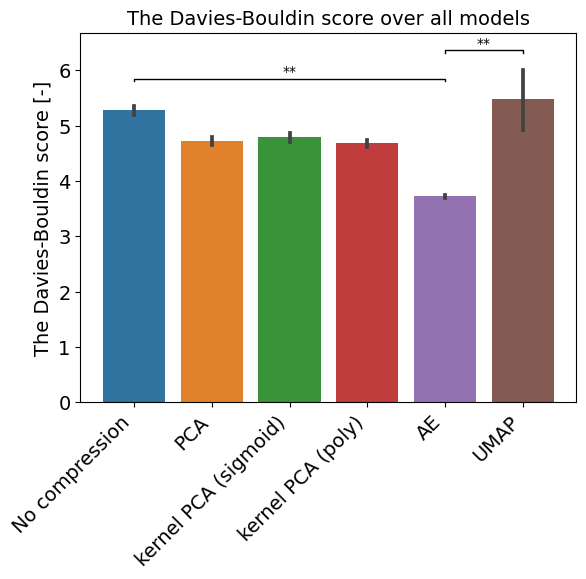

In [ ]:
sns.barplot(data=combined_df, x="Method", y="Davies-Bouldin")
plt.title("The Davies-Bouldin score over all models",fontsize=14)
plt.ylabel("The Davies-Bouldin score [-]", fontsize=14)
plt.xlabel("", fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha="right")
plt.yticks(fontsize=14)

x1, x2 = 0, 4 
y, h, col = 5.8, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom')
x1, x2 = 4, 5 
y, h, col = 6.31, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom')
plt.show()

Text(3.0, 0.295, '*')

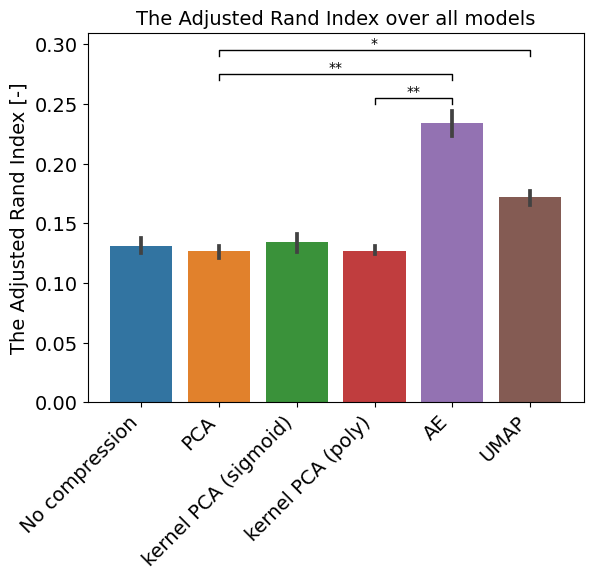

In [ ]:
sns.barplot(data=combined_df, x="Method", y="ARI")
plt.title("The Adjusted Rand Index over all models", fontsize=14)
plt.ylabel("The Adjusted Rand Index [-]", fontsize=14)
plt.xlabel("", fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha="right")
plt.yticks(fontsize=14)

x1, x2 = 3, 4 
y, h, col = 0.25, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom')
x1, x2 = 1, 4 
y, h, col = 0.27, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom')

x1, x2 = 1, 5 
y, h, col = 0.29, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom')

Text(4.5, 0.041, '*')

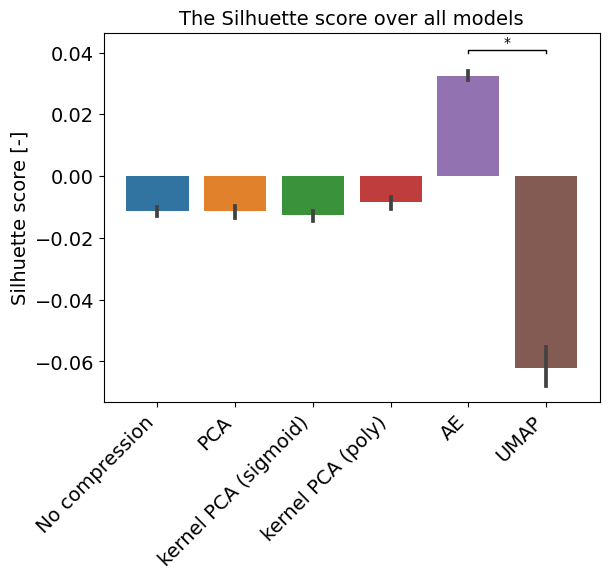

In [ ]:
sns.barplot(data=combined_df, x="Method", y="Silhuette")
plt.title("The Silhuette score over all models", fontsize=14)
plt.ylabel("Silhuette score [-]", fontsize=14)
plt.xlabel("", fontsize=14)
plt.xticks(fontsize=14, rotation=45, ha="right")
plt.yticks(fontsize=14)
x1, x2 = 4, 5 
y, h, col = 0.040, 0.001, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom')

## Stastical comparison of baseline and autoencoder-based models

### Testing normality of the data 

Normality of the data could be checked visually via QQ plot or histagram. However there is a statisticial test that allows to find if data comes from normal distibution - Shapiro-Wilk Test.

In [ ]:
methods = ["No compression", "PCA", "kernel PCA (sigmoid)", "kernel PCA (poly)", "AE",  "UMAP"]

bouldin, ari, silh, labels = [], [], [], []

for method in methods:
  labels.append(method)
  df = combined_df[combined_df["Method"] == method]
  bouldin.append(df["Davies-Bouldin"].tolist())
  ari.append(df["ARI"].tolist())
  silh.append(df["Silhuette"].tolist())

In [ ]:
shapiro(bouldin)

ShapiroResult(statistic=0.909479558467865, pvalue=0.014437713660299778)

In [ ]:
shapiro(ari)

ShapiroResult(statistic=0.7785063982009888, pvalue=2.7253468942944892e-05)

In [ ]:
shapiro(silh)

ShapiroResult(statistic=0.8237898349761963, pvalue=0.0001836761221056804)

Since the p-value is less than .05, we reject the null hypothesis of the Shapiro-Wilk test. This means we have sufficient evidence to say that the sample data does not come from a normal distribution.

### Friedman (non-prametric) test for paired samples

From the statistics above we can conclude that the data are not normally distributed ans we should use non-parametric model. Setting random state in scikit-learn KFold function generate the same data partitions for cross-validation each time when the code is running. This means that the performance metrics from different models will be based on the same data splits, and the samples as paired. The Friedman test is used for comparison of paired samples (non-parametric).



In [ ]:
# Performing on the Davies-Bouldin score
f, p_value = friedmanchisquare(*bouldin)
print('F: %.3f' % f)
print('p-value: %.5f' % p_value)

print(round(p_value*10000, 3), "*10^4")

F: 20.543
p-value: 0.00099
9.88 *10^4


In [ ]:
# Performing on the Silhuette score
f, p_value = friedmanchisquare(*silh)
print('F: %.3f' % f)
print('p-value: %.5f' % p_value)

print(round(p_value*10000,3), "*10^4")

F: 23.953
p-value: 0.00022
2.216 *10^4


In [ ]:
# Performing on the ARI score
f, p_value = friedmanchisquare(*ari)
print('F: %.3f' % f)
print('p-value: %.5f' % p_value)

print(round(p_value*10000, 3), "*10^4")

F: 21.782
p-value: 0.00058
5.761 *10^4


The data above show that there is a significant difference between models, however we do not know which models are different from each other. To identify these pairs of models, Nemenyi post-hoc test is performed.

### Nemenyi post-hoc test

Bonferroni correction was not used to adjust for multiple comparison if Nemenyi test as the Nemenyi test already accounts for multiple comparisons by using the Studentized range distribution (q-distribution) to compute the critical difference. This test is designed to control the family-wise error rate for multiple comparisons in a manner similar to the Bonferroni correction, but with a less conservative approach.

In [ ]:
nemenyi_results = sp.posthoc_nemenyi_friedman(np.array(bouldin).T)
nemenyi_results.columns = nemenyi_results.index = labels
nemenyi_results = round(nemenyi_results, 3)
pd.DataFrame(nemenyi_results).to_csv(f"{path}/nemenyi_results_bouldin.csv", index=True)
nemenyi_results

,No compression,PCA,kernel PCA (sigmoid),kernel PCA (poly),AE,UMAP
No compression,1.000,0.43,0.900,0.075,0.003,0.900
PCA,0.430,1.00,0.900,0.900,0.430,0.630
kernel PCA (sigmoid),0.900,0.90,1.000,0.533,0.075,0.900
kernel PCA (poly),0.075,0.90,0.533,1.000,0.900,0.168
AE,0.003,0.43,0.075,0.900,1.000,0.009
UMAP,0.900,0.63,0.900,0.168,0.009,1.000


In [ ]:
nemenyi_results = sp.posthoc_nemenyi_friedman(np.array(silh).T)
nemenyi_results.columns = nemenyi_results.index = labels
nemenyi_results = round(nemenyi_results, 3)
pd.DataFrame(nemenyi_results).to_csv(f"{path}/nemenyi_results_silh.csv", index=True)
nemenyi_results

,No compression,PCA,kernel PCA (sigmoid),kernel PCA (poly),AE,UMAP
No compression,1.000,0.900,0.900,0.679,0.201,0.376
PCA,0.900,1.000,0.874,0.777,0.280,0.280
kernel PCA (sigmoid),0.900,0.874,1.000,0.168,0.017,0.900
kernel PCA (poly),0.679,0.777,0.168,1.000,0.900,0.009
AE,0.201,0.280,0.017,0.900,1.000,0.001
UMAP,0.376,0.280,0.900,0.009,0.001,1.000


In [ ]:
nemenyi_results = sp.posthoc_nemenyi_friedman(np.array(ari).T)
nemenyi_results = round(nemenyi_results, 3)
nemenyi_results.columns = nemenyi_results.index = labels
pd.DataFrame(nemenyi_results).to_csv(f"{path}/nemenyi_results_ari.csv", index=True)
nemenyi_results

,No compression,PCA,kernel PCA (sigmoid),kernel PCA (poly),AE,UMAP
No compression,1.000,0.777,0.900,0.874,0.139,0.582
PCA,0.777,1.000,0.582,0.900,0.003,0.047
kernel PCA (sigmoid),0.900,0.582,1.000,0.679,0.280,0.777
kernel PCA (poly),0.874,0.900,0.679,1.000,0.005,0.075
AE,0.139,0.003,0.280,0.005,1.000,0.900
UMAP,0.582,0.047,0.777,0.075,0.900,1.000


## Aplication of the autoencoder-based and baseline models to testing data

In [ ]:
y_test = pd.read_csv(f"{path}/y_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0)
#y_test = y_test.reset_index(drop=True)
#y_test.index = test_df.index
y_test.shape

(2156, 7)

In [ ]:
test_df = pd.read_csv(f"{path}/X_test_A_merged_CRC_BRCA.csv.tar.gz", compression = "gzip", index_col=0).T
test_df.shape

(2156, 22596)

### No compression

In [ ]:
all = []
km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(test_df)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(test_df, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(test_df, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

all.append((round(silhouetteScore,3), round(ari,3), round(davies_bouldinScore,3)))

Silhuette: -0.077 ARI 0.175 Davies-Bouldin 4.727


### PCA compression

In [ ]:
pca = PCA(n_components=2408).fit(train_df)
X_test = pca.transform(test_df)

In [ ]:
km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(X_test)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(X_test, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(X_test, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

all.append((round(silhouetteScore,3), round(ari,3), round(davies_bouldinScore,3)))

Silhuette: -0.087 ARI 0.177 Davies-Bouldin 4.388


### kPCA compression (poly)

In [ ]:
pca = KernelPCA(n_components=2408, kernel="poly").fit(train_df)
X_test = pca.transform(test_df)

In [ ]:
km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(X_test)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(X_test, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(X_test, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

all.append((round(silhouetteScore,3), round(ari,3), round(davies_bouldinScore,3)))

Silhuette: -0.08 ARI 0.176 Davies-Bouldin 4.237


### kPCA compression (sigmoid)

In [ ]:
pca = KernelPCA(n_components=2408, kernel="sigmoid").fit(train_df)
X_test = pca.transform(test_df)

In [ ]:
km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(X_test)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(X_test, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(X_test, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

all.append((round(silhouetteScore,3), round(ari,3), round(davies_bouldinScore,3)))

Silhuette: -0.087 ARI 0.171 Davies-Bouldin 4.415


### UMAP compression

In [ ]:
ump = UMAP(n_components=2408, min_dist=0.1, n_neighbors=150).fit(train_df)
X_test = ump.transform(X_test)

In [ ]:
km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(X_test)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(X_test, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(X_test, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

all.append((round(silhouetteScore,3), round(ari,3), round(davies_bouldinScore,3)))

Silhuette: -0.0689999982714653 ARI -0.001 Davies-Bouldin 24.143


In [ ]:
compr_df = pd.DataFrame.from_records(all, columns=["Silhouette", "ARI", "DB score"])
compr_df.index = ["No compression", "PCA", "kPCA (poly)", "kPCA (sigmoid)", "UMAP"]
compr_df.to_csv(f"{path}/testing_data_clustering_metrics.csv", index=True)
compr_df

,Silhouette,ARI,DB score
No compression,-0.077,0.175,4.727
PCA,-0.087,0.177,4.388
kPCA (poly),-0.080,0.176,4.237
kPCA (sigmoid),-0.087,0.171,4.415
UMAP,-0.069,-0.001,24.143


### AE compression

In [ ]:
from keras.models import load_model

# Load the encoder model
loaded_encoder = load_model(f'{path}/ae_encoder.h5', compile=False)

2023-04-17 21:31:16.432969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/ngs/ngs-sdk/lib64:/usr/local/ncbi/ncbi-vdb/lib64:
2023-04-17 21:31:16.433005: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-17 21:31:16.433030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (koios): /proc/driver/nvidia/version does not exist
2023-04-17 21:31:16.457859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropr

In [ ]:
pca = PCA(n_components=4557).fit(train_df)
X_test = pca.transform(test_df)

In [ ]:
X_val_pred = loaded_encoder.predict(X_test, batch_size=1024)
  
km = KMeans(n_clusters=10, random_state=42)
y_pred = km.fit_predict(X_val_pred)
ari = adjusted_rand_score(y_pred, y_test["Label"])

silhouetteScore = silhouette_score(X_val_pred, y_test["Label"], metric="euclidean")
davies_bouldinScore = davies_bouldin_score(X_val_pred, y_test["Label"])

print(f"Silhuette: {round(silhouetteScore,3)}", f"ARI {round(ari,3)}", f"Davies-Bouldin {round(davies_bouldinScore,3)}")

#all.append((round(silhouetteScore,3), round(ari,3), round(davies_bouldinScore,3)))

3/3 [==============================] - 1s 11ms/step
Silhuette: -0.039000000804662704 ARI 0.2 Davies-Bouldin 3.84


## Session info

In [ ]:
import matplotlib
import sklearn
import google.colab

print(umap.__version__)
print(sp.__version__)
print("Pandas", pd.__version__)
print("Numpy", np.__version__)
print("Matplotlib", matplotlib.__version__)
print("Seaborn", sns.__version__)
print("colab", google.colab.__version__)
print("sklearn", sklearn.__version__)